In [1]:
import numpy as np
import pandas as pd
import torch
import gpytorch
from sklearn.model_selection import train_test_split

In [2]:
from importlib import resources as impresources
import yaml
from recurrent_health_events_prediction import configs

with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [3]:
DATASET = "relapse"

In [4]:
base_training_data_path = data_config['training_data'][DATASET]['preprocessed_path']
print(f"{base_training_data_path}")

/workspaces/master-thesis-recurrent-health-events-prediction/data/avh-data-preprocessed


In [5]:
if DATASET == "relapse":
    training_data_path = base_training_data_path + "/all_drug_tests.csv"
    evaluation_data_path = base_training_data_path + "/relapse_cleaned/last_relapses.csv"

In [6]:
all_drug_tests_df = pd.read_csv(training_data_path)
last_events_df = pd.read_csv(evaluation_data_path)

all_drug_tests_df['DRUG_POSITIVE'] = all_drug_tests_df['DRUG_POSITIVE'].astype(int)

In [7]:
all_drug_tests_df.head()

,DONOR_ID,TIME,COLLECTION_ID,DRUG_POSITIVE,SHOWEDUP,PROGRAM_TYPE,NUM_DRUGS_TESTED,DRUGS_TESTED,POSITIVE_DRUGS,NUM_DRUGS_POSITIVE,...,DRUG_POSITIVE_PAST_MEAN,DRUG_POSITIVE_PAST_SUM,RACE,AGE,GENDER,LOG_TIME_SINCE_LAST_NEGATIVE,LOG_TIME_SINCE_LAST_POSITIVE,LOG_PARTICIPATION_DAYS,LOG_TIME_UNTIL_NEXT_POSITIVE,IS_HISTORICAL_EVENT
0,10012,2014-11-07,1185223,1,True,Probation,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,['Alcohol'],1,...,NaN,NaN,caucasian,17,MALE,NaN,NaN,0.693147,7.159292,True
1,10012,2014-11-10,1188650,0,True,Probation,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,1.000000,1.0,caucasian,17,MALE,NaN,1.386294,1.386294,7.156956,True
2,10012,2014-11-11,1191803,0,True,Probation,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0.500000,1.0,caucasian,17,MALE,0.693147,1.609438,1.609438,7.156177,True
3,10012,2014-11-15,1209319,0,True,Probation,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,[],0,...,0.333333,1.0,caucasian,17,MALE,1.609438,2.197225,2.197225,7.153052,True
4,10012,2014-11-28,1245617,0,True,Probation,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,[],0,...,0.250000,1.0,caucasian,17,MALE,2.639057,3.091042,3.091042,7.142827,True


In [8]:
all_drug_tests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748832 entries, 0 to 1748831
Data columns (total 31 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   DONOR_ID                           int64  
 1   TIME                               object 
 2   COLLECTION_ID                      int64  
 3   DRUG_POSITIVE                      int64  
 4   SHOWEDUP                           bool   
 5   PROGRAM_TYPE                       object 
 6   NUM_DRUGS_TESTED                   int64  
 7   DRUGS_TESTED                       object 
 8   POSITIVE_DRUGS                     object 
 9   NUM_DRUGS_POSITIVE                 int64  
 10  FIRST_TEST_TIME                    object 
 11  PARTICIPATION_DAYS                 int64  
 12  PREV_TEST_TIME                     object 
 13  NEXT_TEST_TIME                     object 
 14  TIME_SINCE_LAST_TEST               float64
 15  TIME_UNTIL_NEXT_TEST               float64
 16  TIME_SINCE_LAST_NE

### Utils

In [3]:
def add_last_positive_test_columns(
    df,
    drug_cols,
    group_col='DONOR_ID',
    time_col='PARTICIPATION_DAYS',
    signal_col='DRUG_POSITIVE'
):
    """
    Adds columns LAST_POS_TEST_<DRUG>_POS for each drug in drug_cols.
    Each new column contains the value of the corresponding drug test
    from the most recent *prior* row where DRUG_POSITIVE == 1 for the same donor.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        drug_cols (list of str): Drug test columns to track.
        group_col (str): Group identifier (e.g., 'DONOR_ID').
        time_col (str): Time ordering column (e.g., 'PARTICIPATION_DAYS').
        signal_col (str): Binary signal column (e.g., 'DRUG_POSITIVE').

    Returns:
        pd.DataFrame: DataFrame with new LAST_POS_TEST_<DRUG>_POS columns.
    """
    df_sorted = df.sort_values([group_col, time_col]).copy()

    for drug in drug_cols:
        new_col = f'LAST_POS_TEST_{drug}'

        # Keep only values of the drug where DRUG_POSITIVE == 1
        masked = df_sorted[drug].where(df_sorted[signal_col] == 1)

        # Shift to ensure we get *prior* positive rows
        shifted = masked.groupby(df_sorted[group_col]).shift()

        # Forward fill the last known DRUG_POSITIVE==1 value
        df_sorted[new_col] = shifted.groupby(df_sorted[group_col]).ffill()

        # Don't fillna — keep NaN for cases where no previous positive exists
        # You can cast to int after fillna if you prefer, but leave as float to preserve NaN

    return df_sorted

In [4]:
def preprocess_drug_cols(df, drugs_selected_cols):
    all_drug_cols = [col for col in df.columns if col.endswith('_POS')]
    cols_to_summarize = list(set(all_drug_cols) - set(drugs_selected_cols))
    df['OTHER_DRUGS_POS'] = (df[cols_to_summarize] == 1).any(axis=1).astype(int)
    final_drug_cols = drugs_selected_cols + ['OTHER_DRUGS_POS']
    return df, final_drug_cols

def create_shifted_drug_columns(df, drug_cols_to_shift, group_col='DONOR_ID'):
    drug_cols_renamed = ['PREV_' + col for col in drug_cols_to_shift]
    df[drug_cols_renamed] = df.groupby(group_col)[drug_cols_to_shift].shift(1).fillna(0)
    return df, drug_cols_renamed

In [5]:
# Define the example data with two donors
data = {
    'DONOR_ID': [
        1, 1, 1, 1, 1,      # Donor 1
        2, 2, 2, 2, 2       # Donor 2
    ],
    'PARTICIPATION_DAYS': [
        1, 2, 3, 4, 5,      # Donor 1 timeline
        1, 3, 4, 7, 9       # Donor 2 timeline (irregular)
    ],
    'DRUG_POSITIVE': [
        1, 0, 0, 1, 0,      # Donor 1 pattern
        0, 1, 0, 1, 0       # Donor 2 pattern
    ],
    'CANNABINOIDS_POS': [
        1, 0, 0, 0, 0,      # Donor 1
        0, 1, 0, 0, 0       # Donor 2
    ],
    'ALCOHOL_POS': [
        0, 0, 0, 1, 0,      # Donor 1
        0, 0, 0, 1, 0       # Donor 2
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Optional: sort and display
df = df.sort_values(['DONOR_ID', 'PARTICIPATION_DAYS']).reset_index(drop=True)
df

,DONOR_ID,PARTICIPATION_DAYS,DRUG_POSITIVE,CANNABINOIDS_POS,ALCOHOL_POS
0,1,1,1,1,0
1,1,2,0,0,0
2,1,3,0,0,0
3,1,4,1,0,1
4,1,5,0,0,0
5,2,1,0,0,0
6,2,3,1,1,0
7,2,4,0,0,0
8,2,7,1,0,1
9,2,9,0,0,0


In [6]:
add_last_positive_test_columns(
    df,
    ["CANNABINOIDS_POS", "ALCOHOL_POS"],
    group_col="DONOR_ID",
    time_col="PARTICIPATION_DAYS",
    signal_col="DRUG_POSITIVE",
)

,DONOR_ID,PARTICIPATION_DAYS,DRUG_POSITIVE,CANNABINOIDS_POS,ALCOHOL_POS,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_ALCOHOL_POS
0,1,1,1,1,0,NaN,NaN
1,1,2,0,0,0,1.0,0.0
2,1,3,0,0,0,1.0,0.0
3,1,4,1,0,1,1.0,0.0
4,1,5,0,0,0,0.0,1.0
5,2,1,0,0,0,NaN,NaN
6,2,3,1,1,0,NaN,NaN
7,2,4,0,0,0,1.0,0.0
8,2,7,1,0,1,1.0,0.0
9,2,9,0,0,0,0.0,1.0


In [7]:
def build_dense_donor_timeline(df_donor, step=7):
    """
    Build a dense timeline for a single donor, with interpolated/forward-filled covariates.
    Assumes LAST_POS_TEST_<DRUG>_POS columns are already present.

    Parameters:
        df_donor (pd.DataFrame): Donor-specific data (must include PARTICIPATION_DAYS, DRUG_POSITIVE, *_POS, LAST_POS_TEST_*).
        step (int): Step size for interpolation (e.g., 7 for weekly steps).

    Returns:
        pd.DataFrame: Dense timeline for the donor.
    """
    df_donor = df_donor.sort_values("PARTICIPATION_DAYS").copy()

    time_col = "PARTICIPATION_DAYS"
    signal_col = "DRUG_POSITIVE"
    donor_id = df_donor["DONOR_ID"].iloc[0]

    original_times = df_donor[time_col].unique()

    # Identify covariates to forward-fill
    drug_cols = [col for col in df_donor.columns if col.endswith("_POS") and col != signal_col]
    last_pos_cols = [col for col in df_donor.columns if col.startswith("LAST_POS_TEST_")]

    # Compute LAST_POS_DAY (time of previous DRUG_POSITIVE)
    last_pos_day = df_donor[time_col].where(df_donor[signal_col] == 1)
    df_donor["LAST_POS_DAY"] = last_pos_day.shift().ffill()
    df_donor["DAYS_SINCE_LAST_POSITIVE"] = df_donor[time_col] - df_donor["LAST_POS_DAY"]
    df_donor["LOG_DAYS_SINCE_LAST_POSITIVE"] = np.log(df_donor["DAYS_SINCE_LAST_POSITIVE"].clip(lower=1e-6))

    # Build dense timeline with step and all observed points
    min_day = df_donor[time_col].min()
    max_day = df_donor[time_col].max()
    dense_days = pd.Series(np.arange(min_day, max_day + 1, step), name=time_col)
    observed_days = df_donor[time_col].unique()
    all_days = pd.Series(np.union1d(dense_days, observed_days), name=time_col)

    df_dense = pd.DataFrame({time_col: all_days})
    df_dense["DONOR_ID"] = donor_id

    # Merge with donor data using merge_asof
    df_donor_sorted = df_donor.sort_values(time_col)
    df_dense_sorted = df_dense.sort_values(time_col)

    # List of columns to carry forward
    fill_cols = [signal_col] + drug_cols + last_pos_cols + ["LOG_DAYS_SINCE_LAST_POSITIVE"]

    df_merged = pd.merge_asof(
        df_dense_sorted,
        df_donor_sorted[[time_col] + fill_cols],
        on=time_col,
        direction="backward"
    )

    df_merged["DONOR_ID"] = donor_id
    df_merged["ORIGINAL_SAMPLE"] = df_merged[time_col].isin(original_times).astype(int)

    return df_merged.reset_index(drop=True)

In [8]:
def densify_and_recompute_last_pos(df_donor, step=7):
    """
    Create dense timeline for a donor, forward-fill drug results, and recompute LAST_POS_TEST_<DRUG>_POS columns.
    
    Parameters:
        df_donor (pd.DataFrame): Data for one donor.
        step (int): Number of days between synthetic samples.

    Returns:
        pd.DataFrame: Densified and filled timeline with LAST_POS_TEST_* columns recomputed.
    """
    df_donor = df_donor.sort_values("PARTICIPATION_DAYS").copy()
    donor_id = df_donor["DONOR_ID"].iloc[0]
    time_col = "PARTICIPATION_DAYS"
    signal_col = "DRUG_POSITIVE"

    original_sample_times = df_donor[time_col].unique()

    # Identify drug covariates (excluding DRUG_POSITIVE)
    drug_cols = [col for col in df_donor.columns if col.endswith("_POS") and col != signal_col]

    # Step 1: Create dense timeline (including observed + step intervals)
    min_day = df_donor[time_col].min()
    max_day = df_donor[time_col].max()
    dense_days = pd.Series(np.arange(min_day, max_day + 1, step))
    observed_days = df_donor[time_col].unique()
    all_days = np.union1d(dense_days, observed_days)

    df_dense = pd.DataFrame({time_col: all_days})
    df_dense["DONOR_ID"] = donor_id

    # Step 2: Merge with original data and forward-fill
    df_full = pd.merge(df_dense, df_donor, on=[time_col, "DONOR_ID"], how="left")
    df_full = df_full.sort_values(time_col)
    df_full[[signal_col] + drug_cols] = df_full[[signal_col] + drug_cols].ffill()

    # Step 3: Recompute LAST_POS_TEST_<DRUG>_POS from scratch
    for drug in drug_cols:
        new_col = f"LAST_POS_TEST_{drug}"
        # Mask drug value only where DRUG_POSITIVE == 1
        mask = df_full[drug].where(df_full[signal_col] == 1)
        # Shift to exclude current row if it's a positive
        last_pos = mask.shift().ffill()
        df_full[new_col] = last_pos
    
    df_full["ORIGINAL_SAMPLE"] = df_full[time_col].isin(original_sample_times).astype(int)

    df_full[signal_col] = np.where(df_full["ORIGINAL_SAMPLE"] == 1, df_full[signal_col], 0)
    for drug in drug_cols:
        df_full[drug] = np.where(df_full["ORIGINAL_SAMPLE"] == 1, df_full[drug], np.nan)

    return df_full.reset_index(drop=True)

def compute_log_time_since_last_positive(df, time_col="PARTICIPATION_DAYS", signal_col="DRUG_POSITIVE"):
    """
    Adds a column LOG_TIME_SINCE_LAST_POSITIVE to the DataFrame.
    Assumes DataFrame is sorted by time and belongs to a single donor.
    """
    # 1. Identify PARTICIPATION_DAYS where DRUG_POSITIVE == 1
    last_pos_day = df[time_col].where(df[signal_col] == 1)

    # 2. Shift to exclude current row, then forward-fill to get most recent prior positive day
    last_pos_day = last_pos_day.shift().ffill()

    # 3. Compute delta
    delta = df[time_col] - last_pos_day

    # 4. Take log, clip to avoid log(0)
    df["LOG_TIME_SINCE_LAST_POSITIVE"] = np.log(delta.clip(lower=1e-6))

    return df

def fill_drug_positive_past_sum(df, signal_col='DRUG_POSITIVE', group_col='DONOR_ID'):
    """
    Computes the cumulative sum of DRUG_POSITIVE before the current row
    for all rows, including synthetic ones.

    Parameters:
        df: DataFrame with synthetic and original rows
        signal_col: The name of the DRUG_POSITIVE column
        group_col: The name of the grouping column (e.g., DONOR_ID)

    Returns:
        df with a new column: DRUG_POSITIVE_PAST_SUM
    """
    df = df.sort_values([group_col, 'PARTICIPATION_DAYS']).copy()

    # Grouped cumsum, then shift within each group
    df['DRUG_POSITIVE_PAST_SUM'] = (
        df.groupby(group_col)[signal_col]
          .cumsum()
          .groupby(df[group_col])
          .shift()
    )

    return df


In [9]:
# Simulated sparse donor data
data = {
    'DONOR_ID': [1] * 7,
    'PARTICIPATION_DAYS': [1, 4, 6, 13, 20, 30, 31],
    'DRUG_POSITIVE': [1, 0, 0, 1, 0, 1, 1],
    'CANNABINOIDS_POS': [1, 0, 0, 0, 0, 1, 0],
    'ALCOHOL_POS': [0, 0, 0, 1, 0, 1, 1],
    'DRUG_POSITIVE_PAST_SUM': [0, 1, 1, 1, 2, 2, 3],
}

df_donor = pd.DataFrame(data).sort_values("PARTICIPATION_DAYS").reset_index(drop=True)
df_donor

,DONOR_ID,PARTICIPATION_DAYS,DRUG_POSITIVE,CANNABINOIDS_POS,ALCOHOL_POS,DRUG_POSITIVE_PAST_SUM
0,1,1,1,1,0,0
1,1,4,0,0,0,1
2,1,6,0,0,0,1
3,1,13,1,0,1,1
4,1,20,0,0,0,2
5,1,30,1,1,1,2
6,1,31,1,0,1,3


In [ ]:
df_donor = densify_and_recompute_last_pos(df_donor, step=2)

In [ ]:
df_donor = compute_log_time_since_last_positive(df_donor)

In [12]:
df_donor = fill_drug_positive_past_sum(df_donor)

### Sampling Donors

In [20]:
sampled_donors = all_drug_tests_df['DONOR_ID'].drop_duplicates().sample(n=2000, random_state=42)
sampled_data_df = all_drug_tests_df[all_drug_tests_df['DONOR_ID'].isin(sampled_donors)].copy()

In [21]:
print("Num of samples: ", len(sampled_data_df))

Num of samples:  53822


In [22]:
df = sampled_data_df.groupby('DONOR_ID').agg({"DRUG_POSITIVE": "mean", 'COLLECTION_ID': "count"})
mask = (df['DRUG_POSITIVE'] < 0.55) & (df['DRUG_POSITIVE'] > 0.45)
mask2 =( df['COLLECTION_ID'] > 10) & (df['COLLECTION_ID'] < 30)
df[mask & mask2]

,DRUG_POSITIVE,COLLECTION_ID
DONOR_ID,,
668899,0.500000,28
724497,0.470588,17
1143294,0.454545,11
1542631,0.454545,11
1592787,0.538462,13
1700506,0.454545,11
1757412,0.500000,12
1934034,0.454545,22
1937198,0.470588,17


### Filling Missing Values

In [23]:
sampled_data_df.describe()

,DONOR_ID,COLLECTION_ID,DRUG_POSITIVE,NUM_DRUGS_TESTED,NUM_DRUGS_POSITIVE,PARTICIPATION_DAYS,TIME_SINCE_LAST_TEST,TIME_UNTIL_NEXT_TEST,TIME_SINCE_LAST_NEGATIVE,TIME_SINCE_LAST_POSITIVE,TIME_UNTIL_NEXT_POSITIVE,NUM_NEGATIVES_SINCE_LAST_POSITIVE,NUM_POSITIVES_SINCE_LAST_NEGATIVE,DRUG_POSITIVE_PAST_MEAN,DRUG_POSITIVE_PAST_SUM,AGE,LOG_TIME_SINCE_LAST_NEGATIVE,LOG_TIME_SINCE_LAST_POSITIVE,LOG_PARTICIPATION_DAYS,LOG_TIME_UNTIL_NEXT_POSITIVE
count,5.382200e+04,5.382200e+04,53822.000000,53822.000000,53822.000000,53822.000000,51822.000000,51822.000000,47977.000000,43696.000000,35030.000000,43696.000000,39518.000000,51822.000000,51822.000000,53822.000000,47977.000000,43696.000000,53822.000000,35030.000000
mean,5.009522e+06,1.474024e+07,0.265765,5.871168,0.311471,336.010312,17.246227,17.246227,34.309690,126.070304,121.906223,16.920016,0.272559,0.300721,8.881788,34.302664,2.377901,3.810211,5.069337,3.581626
std,2.947131e+06,8.117665e+06,0.441744,2.210107,0.567551,424.162422,65.927954,65.927954,103.997929,195.628744,258.039471,30.056351,1.768172,0.335309,18.288543,11.024509,1.310022,1.590484,1.487229,1.624428
min,1.123400e+04,9.159310e+05,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.693147,0.693147,0.693147,0.693147
25%,2.598416e+06,7.567468e+06,0.000000,5.000000,0.000000,81.000000,3.000000,3.000000,3.000000,11.000000,8.000000,0.000000,0.000000,0.026316,1.000000,26.000000,1.386294,2.484907,4.406719,2.197225
50%,4.963405e+06,1.461907e+07,0.000000,6.000000,0.000000,209.000000,6.000000,6.000000,7.000000,51.000000,36.000000,4.000000,0.000000,0.148148,3.000000,33.000000,2.079442,3.951244,5.347108,3.610918
75%,7.685360e+06,2.154506e+07,1.000000,7.000000,1.000000,420.000000,12.000000,12.000000,22.000000,157.000000,123.000000,19.000000,0.000000,0.500000,8.000000,41.000000,3.135494,5.062595,6.042633,4.820282
max,9.987435e+06,2.960772e+07,1.000000,17.000000,5.000000,3641.000000,2702.000000,2702.000000,2571.000000,2856.000000,2856.000000,218.000000,122.000000,1.000000,203.000000,75.000000,7.852439,7.957527,8.200288,7.957527


In [24]:
sampled_data_df['TIME_SINCE_LAST_POSITIVE'] = np.where(
    sampled_data_df['TIME_SINCE_LAST_POSITIVE'].isna(),
    sampled_data_df['PARTICIPATION_DAYS'] + 30,
    sampled_data_df['TIME_SINCE_LAST_POSITIVE'])

sampled_data_df['LOG_TIME_SINCE_LAST_POSITIVE'] = np.log(sampled_data_df['TIME_SINCE_LAST_POSITIVE'])
sampled_data_df['LOG_TIME_SINCE_LAST_POSITIVE'] = sampled_data_df['LOG_TIME_SINCE_LAST_POSITIVE'].clip(lower=1e-6)

### Preprocessing Drug Positive Columns

In [25]:
from recurrent_health_events_prediction.preprocessing.utils import hot_encode_drug_classes

sampled_data_df = hot_encode_drug_classes(sampled_data_df, 'POSITIVE_DRUGS')

In [26]:
all_drug_cols = [col for col in sampled_data_df.columns if col.endswith('_POS')]
drug_means = sampled_data_df[all_drug_cols].mean()
drug_means.name = 'MEAN_DRUG_POSITIVE'
drug_means

ALCOHOL_POS                     0.038107
AMPHETAMINES_POS                0.055646
ANTICONVULSANTS_POS             0.002322
BARBITURATES_POS                0.000130
BENZODIAZEPINES_POS             0.017261
BUPRENORPHINE_POS               0.020865
CANNABINOIDS_POS                0.122924
COCAINE_POS                     0.015607
DISSOCIATIVE ANESTHETICS_POS    0.001839
FENTANYL_POS                    0.007097
KETAMINE_POS                    0.000019
KRATOM_POS                      0.000186
LSD_POS                         0.000111
METHADONE_POS                   0.009903
OPIATES_POS                     0.019063
OPIOIDS_POS                     0.000130
OTHER_POS                       0.000149
ZOLPIDEM_POS                    0.000111
Name: MEAN_DRUG_POSITIVE, dtype: float64

In [27]:
drugs_selected_cols = ['CANNABINOIDS_POS', 'BUPRENORPHINE_POS', 'ALCOHOL_POS', 'AMPHETAMINES_POS']
sampled_data_df, drug_cols_to_shift = preprocess_drug_cols(sampled_data_df, drugs_selected_cols)


In [28]:
sampled_data_df = add_last_positive_test_columns(
    sampled_data_df,
    drug_cols_to_shift,
    group_col="DONOR_ID",
    time_col="PARTICIPATION_DAYS",
    signal_col="DRUG_POSITIVE",
)
sampled_data_df.head()

,DONOR_ID,TIME,COLLECTION_ID,DRUG_POSITIVE,SHOWEDUP,PROGRAM_TYPE,NUM_DRUGS_TESTED,DRUGS_TESTED,POSITIVE_DRUGS,NUM_DRUGS_POSITIVE,...,OPIATES_POS,OPIOIDS_POS,OTHER_POS,ZOLPIDEM_POS,OTHER_DRUGS_POS,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS
1509,11234,2015-11-16,2181184,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1510,11234,2015-11-30,2212986,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1511,11234,2015-12-15,2247389,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1512,11234,2015-12-23,2266810,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1513,11234,2015-12-28,2269768,0,True,Juvenile Court,1,['Alcohol'],[],0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [29]:
# sampled_data_df, drug_cols_renamed = create_shifted_drug_columns(sampled_data_df, drug_cols_to_shift)
cols = [col for col in sampled_data_df.columns if col.startswith('LAST_POS_TEST_') and col != 'LAST_POS_TEST_OTHER_DRUGS_POS']
sampled_data_df[cols] = sampled_data_df[cols].fillna(0).astype(int)
sampled_data_df['LAST_POS_TEST_OTHER_DRUGS_POS'] = sampled_data_df['LAST_POS_TEST_OTHER_DRUGS_POS'].fillna(1).astype(int)

In [30]:
sampled_data_df[['DRUG_POSITIVE'] + cols + ['LAST_POS_TEST_OTHER_DRUGS_POS']].head()

,DRUG_POSITIVE,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS
1509,0,0,0,0,0,1
1510,0,0,0,0,0,1
1511,0,0,0,0,0,1
1512,0,0,0,0,0,1
1513,0,0,0,0,0,1


### Train Test Historical Split

In [31]:
from recurrent_health_events_prediction.preprocessing.utils import get_past_events, get_last_event

sampled_data_df = sampled_data_df.sort_values(by=['DONOR_ID', 'PARTICIPATION_DAYS'])

X_test = get_last_event(sampled_data_df, 'DONOR_ID')
X_train = get_past_events(sampled_data_df, 'DONOR_ID')

In [32]:
X_test['DRUG_POSITIVE'].value_counts(normalize=True)

DRUG_POSITIVE
0    0.674
1    0.326
Name: proportion, dtype: float64

In [33]:
X_train['DRUG_POSITIVE'].value_counts(normalize=True)

DRUG_POSITIVE
0    0.73656
1    0.26344
Name: proportion, dtype: float64

### GP Classifier Training

In [34]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsGP import RecurrentHealthEventsGP, KernelType

cols_last_pos = cols = [col for col in sampled_data_df.columns if col.startswith('LAST_POS_TEST_')]
config = {
    "batch_size": 64,
    "lr": 0.001,
    "epochs": 40,
    "num_inducing": 64,
    "time_feature": "PARTICIPATION_DAYS",
    "target_col": "DRUG_POSITIVE",
    "step_size": 20,
    "gamma": 0.5,
    "kernel_type": KernelType.RBF,
    "binary_features": cols_last_pos
}

features = [
    "PARTICIPATION_DAYS",
    "LOG_TIME_SINCE_LAST_POSITIVE",
    "DRUG_POSITIVE_PAST_SUM"
] + cols_last_pos

In [35]:
X_train[features + [config['target_col']]].describe()

,PARTICIPATION_DAYS,LOG_TIME_SINCE_LAST_POSITIVE,DRUG_POSITIVE_PAST_SUM,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS,DRUG_POSITIVE
count,51822.000000,51822.000000,49822.000000,51822.000000,51822.000000,51822.000000,51822.000000,51822.000000,51822.000000
mean,331.731948,3.873529,8.964313,0.273590,0.032824,0.222087,0.147814,0.389892,0.263440
std,422.495401,1.622696,18.417572,0.445805,0.178177,0.415653,0.354919,0.487730,0.440503
min,1.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78.000000,2.772589,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,205.000000,4.060443,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,414.000000,5.105945,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3617.000000,7.952967,202.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
X_test[features + [config['target_col']]].describe()

,PARTICIPATION_DAYS,LOG_TIME_SINCE_LAST_POSITIVE,DRUG_POSITIVE_PAST_SUM,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS,DRUG_POSITIVE
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000
mean,446.867000,4.289739,6.826000,0.36000,0.019500,0.26100,0.197000,0.26400,0.326000
std,451.466702,1.541897,14.567114,0.48012,0.138309,0.43929,0.397832,0.44091,0.468864
min,2.000000,0.000001,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
25%,152.750000,3.258097,1.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
50%,310.000000,4.532599,3.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
75%,575.000000,5.408290,6.000000,1.00000,0.000000,1.00000,0.000000,1.00000,1.000000
max,3641.000000,7.957177,203.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000


In [37]:
X_train['DRUG_POSITIVE_PAST_SUM'] = X_train['DRUG_POSITIVE_PAST_SUM'].fillna(0)
X_test['DRUG_POSITIVE_PAST_SUM'] = X_test['DRUG_POSITIVE_PAST_SUM'].fillna(0)

In [38]:
gp_model = RecurrentHealthEventsGP(config=config, features=features)
gp_model.fit(X_train)

Epoch 1/40 - Loss: 517.8152 - LR: 0.001000
Epoch 2/40 - Loss: 368.5234 - LR: 0.001000
Epoch 3/40 - Loss: 346.6671 - LR: 0.001000
Epoch 4/40 - Loss: 338.9889 - LR: 0.001000
Epoch 5/40 - Loss: 334.9749 - LR: 0.001000
Epoch 6/40 - Loss: 332.5278 - LR: 0.001000
Epoch 7/40 - Loss: 330.9891 - LR: 0.001000
Epoch 8/40 - Loss: 330.0283 - LR: 0.001000
Epoch 9/40 - Loss: 328.9221 - LR: 0.001000
Epoch 10/40 - Loss: 328.2720 - LR: 0.001000
Epoch 11/40 - Loss: 327.5400 - LR: 0.001000
Epoch 12/40 - Loss: 326.8935 - LR: 0.001000
Epoch 13/40 - Loss: 326.7435 - LR: 0.001000
Epoch 14/40 - Loss: 326.3067 - LR: 0.001000
Epoch 15/40 - Loss: 325.9938 - LR: 0.001000
Epoch 16/40 - Loss: 325.6467 - LR: 0.001000
Epoch 17/40 - Loss: 325.3777 - LR: 0.001000
Epoch 18/40 - Loss: 325.2236 - LR: 0.001000
Epoch 19/40 - Loss: 325.3243 - LR: 0.001000
Epoch 20/40 - Loss: 324.8975 - LR: 0.001000
Epoch 21/40 - Loss: 324.2450 - LR: 0.000500
Epoch 22/40 - Loss: 324.3289 - LR: 0.000500
Epoch 23/40 - Loss: 324.1021 - LR: 0.0005

In [39]:
features_lengthscales = np.concat(([gp_model.model.kernel_time.lengthscale.item()], gp_model.model.kernel_others.base_kernel.lengthscale.detach().cpu().numpy().flatten()))
features_lengthscales_dict = {feature: lengthscale for feature, lengthscale in zip(features, features_lengthscales)}

print("Features lengthscales:")
for feature, lengthscale in features_lengthscales_dict.items():
    print(f"{feature}: {lengthscale:.4f}")

Features lengthscales:
PARTICIPATION_DAYS: 1.7227
LOG_TIME_SINCE_LAST_POSITIVE: 1.7463
DRUG_POSITIVE_PAST_SUM: 5.4258
LAST_POS_TEST_CANNABINOIDS_POS: 1.9896
LAST_POS_TEST_BUPRENORPHINE_POS: 1.6840
LAST_POS_TEST_ALCOHOL_POS: 2.7419
LAST_POS_TEST_AMPHETAMINES_POS: 2.1286
LAST_POS_TEST_OTHER_DRUGS_POS: 2.5088


In [47]:
import plotly.express as px
import pandas as pd

def plot_gp_train_loss_plotly(gp_model):
    train_loss_curve = gp_model.train_loss_curve
    lr_schedule = gp_model.lr_schedule
    df = pd.DataFrame({
        "Epoch": list(range(1, len(train_loss_curve) + 1)),
        "Negative ELBO Loss": train_loss_curve,
        "Learning Rate": lr_schedule
    })
    
    fig = px.line(df, x="Epoch", y="Negative ELBO Loss", title="GP Classifier Training Loss (Negative ELBO)", hover_data=["Learning Rate"])
    fig.update_traces(mode="lines+markers")
    fig.update_layout(
        xaxis_title="Epoch",
        yaxis_title="Negative ELBO Loss",
        template="plotly_white"
    )
    fig.show()

plot_gp_train_loss_plotly(gp_model)

In [48]:
import pickle
model_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/gp_classifier"
save_model_path = model_path + "/gp_model.pkl"
with open(save_model_path, 'wb') as file:
    pickle.dump(gp_model, file)

In [49]:
train_data_path = model_path + "/X_train.csv"
test_data_path = model_path + "/X_test.csv"

X_train.to_csv(train_data_path, index=False)
X_test.to_csv(test_data_path, index=False)

print(f"Training data saved to: {train_data_path}")
print(f"Test data saved to: {test_data_path}")

Training data saved to: /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/gp_classifier/X_train.csv
Test data saved to: /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/gp_classifier/X_test.csv


### Load Model Saved

In [14]:
from recurrent_health_events_prediction.model.utils import load_model
from recurrent_health_events_prediction.model.RecurrentHealthEventsGP import RecurrentHealthEventsGP, KernelType


model_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/gp_classifier/gp_model.pkl"
gp_model: RecurrentHealthEventsGP = load_model(model_path)

In [15]:
test_data_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/gp_classifier/X_test.csv"
X_test = pd.read_csv(test_data_path)
train_data_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/gp_classifier/X_train.csv"
X_train = pd.read_csv(train_data_path)

### GP Applied to a Donor

In [16]:
X_train.head()

,DONOR_ID,TIME,COLLECTION_ID,DRUG_POSITIVE,SHOWEDUP,PROGRAM_TYPE,NUM_DRUGS_TESTED,DRUGS_TESTED,POSITIVE_DRUGS,NUM_DRUGS_POSITIVE,...,OPIATES_POS,OPIOIDS_POS,OTHER_POS,ZOLPIDEM_POS,OTHER_DRUGS_POS,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS
0,11234,2015-11-16,2181184,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,0,0,0,0,1
1,11234,2015-11-30,2212986,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,0,0,0,0,1
2,11234,2015-12-15,2247389,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,0,0,0,0,1
3,11234,2015-12-23,2266810,0,True,Juvenile Court,5,['Amphetamines' 'Benzodiazepines' 'Cannabinoid...,[],0,...,0,0,0,0,0,0,0,0,0,1
4,11234,2015-12-28,2269768,0,True,Juvenile Court,1,['Alcohol'],[],0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
X_train.groupby('DONOR_ID').agg(
    MEAN_DRUG_POSITIVE=('DRUG_POSITIVE', 'mean'),
    COUNT=('DRUG_POSITIVE', 'count'),
    MAXIMUM_GAP_TIME=('TIME_UNTIL_NEXT_TEST', 'max'),
)

,MEAN_DRUG_POSITIVE,COUNT,MAXIMUM_GAP_TIME
DONOR_ID,,,
11234,0.111111,9,860.0
11738,0.005814,172,147.0
12854,0.760000,50,15.0
13741,0.166667,24,36.0
15698,0.020000,100,536.0
...,...,...,...
9972572,0.528926,121,47.0
9982373,0.333333,3,27.0
9985401,0.285714,63,22.0


In [42]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid
import pandas as pd
import gpytorch

def plot_predicted_probability_timeline(
    model,
    df: pd.DataFrame,
    donor_id: str,
    original_sample_col: str = "ORIGINAL_SAMPLE"
):
    """
    Plot predicted probability and observed target over time for a given donor,
    with visual distinction for synthetic samples.

    Parameters:
        model: Trained GP model wrapper
        df: DataFrame containing donor data
        donor_id: The donor ID to visualize
        original_sample_col: Column that flags original vs synthetic samples (1 = original, 0 = synthetic)
    """
    if donor_id not in df['DONOR_ID'].unique():
        raise ValueError(f"DONOR_ID {donor_id} not found in DataFrame.")
    if original_sample_col not in df.columns:
        df[original_sample_col] = 1  # Default to synthetic if not present
    
    time_feature = model.time_feature
    target_col = model.target_col

    # Filter donor data
    df_patient = df[df['DONOR_ID'] == donor_id].copy()
    df_patient = df_patient.sort_values(time_feature)

    # Separate continuous and binary features
    continuous_features = [f for f in model.features if f not in model.binary_features]
    continuous_idx = [model.features.index(f) for f in continuous_features]
    binary_idx = [model.features.index(f) for f in model.binary_features]

    # Scale continuous, preserve binary
    X_continuous = df_patient[continuous_features].values
    X_binary = df_patient[model.binary_features].values

    X_cont_scaled = model.scaler.transform(X_continuous)

    # Reconstruct full matrix in original feature order
    X_combined = np.zeros((len(df), len(model.features)), dtype=np.float32)
    for i_cont, i_full in zip(range(len(continuous_idx)), continuous_idx):
        X_combined[:, i_full] = X_cont_scaled[:, i_cont]
    for i_bin, i_full in zip(range(len(binary_idx)), binary_idx):
        X_combined[:, i_full] = X_binary[:, i_bin]
    
    # Convert to tensor
    X_tensor = torch.tensor(X_combined, dtype=torch.float32).to(model.device)

    # Predict latent GP output
    model.model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        latent_dist = model.model(X_tensor)
        latent_mean = latent_dist.mean.cpu().numpy()
        latent_std = latent_dist.stddev.cpu().numpy()

    # Convert to probabilities
    prob_mean = expit(latent_mean)
    prob_upper = expit(latent_mean + 2 * latent_std)
    prob_lower = expit(latent_mean - 2 * latent_std)

    # Extract data for plotting
    times = df_patient[time_feature].values
    y_true = df_patient[target_col].values
    is_original = df_patient[original_sample_col].fillna(0).astype(bool).values

    # Build plot DataFrame
    df_plot = pd.DataFrame({
        "TIME": times,
        "Predicted Probability": prob_mean,
        "Lower": prob_lower,
        "Upper": prob_upper,
        "True Target": y_true,
        "Original": is_original,
    })

    # Plot prediction curve and uncertainty band
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_plot, x="TIME", y="Predicted Probability", label="Predicted Probability", linewidth=2)
    plt.fill_between(df_plot["TIME"], df_plot["Lower"], df_plot["Upper"], alpha=0.3, label="±2 std dev")

    # Plot original sample targets
    df_orig = df_plot[df_plot["Original"]]
    df_pos = df_orig[df_orig["True Target"] == 1]
    df_neg = df_orig[df_orig["True Target"] == 0]

    plt.scatter(df_pos["TIME"], df_pos["True Target"], color="red", label="True Positive", zorder=5, s=50)
    plt.scatter(df_neg["TIME"], df_neg["True Target"], color="green", label="True Negative", zorder=5, s=50)

    # Plot synthetic samples as gray dots at y=0
    df_synth = df_plot[~df_plot["Original"]]
    plt.scatter(df_synth["TIME"], [0]*len(df_synth), color="gray", label="Synthetic", alpha=0.5, s=20, zorder=4)

    # Final formatting
    plt.title(f"Predicted Probability Over Time for DONOR_ID = {donor_id}")
    plt.xlabel("Time")
    plt.ylabel("Probability of DRUG_POSITIVE")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_plot

In [18]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid
import pandas as pd

def plot_latent_function_timeline(model, df: pd.DataFrame, donor_id: str):
    """
    Plot latent function and observed target over time for a given donor.
    
    Parameters:
        model: Trained RecurrentHealthEventsGP object
        df: DataFrame with donor data (must contain 'DONOR_ID', 'TIME', features, and target_col)
        donor_id: The ID of the donor to plot
    """
    if donor_id not in df['DONOR_ID'].unique():
        raise ValueError(f"DONOR_ID {donor_id} not found in DataFrame.")
    
    time_feature = model.time_feature
    target_col = model.target_col

    # Filter and sort patient data
    df_patient = df[df['DONOR_ID'] == donor_id].copy()
    df_patient = df_patient.sort_values(time_feature)
    
    # Extract input features and scale
    X = df_patient[model.features].values
    X_scaled = model.scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(model.device)

    # Model eval mode
    model.model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        latent_dist = model.model(X_tensor)
        mean = latent_dist.mean.cpu().numpy()
        std = latent_dist.stddev.cpu().numpy()
    
    # Get other relevant data
    times = df_patient[time_feature].values
    y_true = df_patient[target_col].values

    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        "TIME": times,
        "Latent Mean": mean,
        "Lower": mean - 2 * std,
        "Upper": mean + 2 * std,
        "Target": y_true,
    })

    # Plot with seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_plot, x="TIME", y="Latent Mean", label="Latent f(x)", linewidth=2)
    plt.fill_between(df_plot["TIME"], df_plot["Lower"], df_plot["Upper"], alpha=0.3, label="±2 std dev")

    # Overlay the true targets
    sns.scatterplot(data=df_plot, x="TIME", y="Target", color="red", label="True Target", zorder=5, s=50)

    plt.title(f"Latent Function Evolution for DONOR_ID = {donor_id}")
    plt.xlabel("Time")
    plt.ylabel("Latent Function Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [33]:
X_train[X_train['DONOR_ID'] == 16632].LOG_TIME_SINCE_LAST_POSITIVE

355    3.433987
356    1.609438
357    2.197225
358    2.944439
359    1.791759
360    2.079442
361    1.791759
362    2.564949
363    2.833213
364    0.693147
365    2.302585
366    2.397895
367    1.791759
368    2.079442
369    5.332719
370    5.342334
371    5.463832
372    5.579730
373    2.484907
374    5.365976
375    5.375278
376    5.398163
377    2.833213
378    3.178054
379    1.386294
380    2.890372
381    1.098612
382    2.639057
383    3.044522
384    0.693147
385    3.295837
386    2.079442
387    3.555348
388    2.079442
389    3.044522
390    3.367296
391    2.944439
392    2.772589
393    3.555348
394    3.891820
395    3.931826
396    4.276666
397    5.123964
398    1.945910
399    2.079442
400    1.945910
401    2.484907
402    1.945910
Name: LOG_TIME_SINCE_LAST_POSITIVE, dtype: float64

In [49]:
donor_df = X_train[X_train['DONOR_ID'] == 16632].copy()
donor_df

,DONOR_ID,TIME,COLLECTION_ID,DRUG_POSITIVE,SHOWEDUP,PROGRAM_TYPE,NUM_DRUGS_TESTED,DRUGS_TESTED,POSITIVE_DRUGS,NUM_DRUGS_POSITIVE,...,OPIATES_POS,OPIOIDS_POS,OTHER_POS,ZOLPIDEM_POS,OTHER_DRUGS_POS,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS
355,16632,2015-07-17,1894152,1,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,['Benzodiazepines'],1,...,0,0,0,0,1,0,0,0,0,1
356,16632,2015-07-22,1903689,0,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,[],0,...,0,0,0,0,0,0,0,0,0,1
357,16632,2015-07-26,1911848,0,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,[],0,...,0,0,0,0,0,0,0,0,0,1
358,16632,2015-08-05,1936043,1,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,['Benzodiazepines'],1,...,0,0,0,0,1,0,0,0,0,1
359,16632,2015-08-11,1948977,1,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,['Benzodiazepines'],1,...,0,0,0,0,1,0,0,0,0,1
360,16632,2015-08-19,1967350,1,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,['Opiates'],1,...,1,0,0,0,1,0,0,0,0,1
361,16632,2015-08-25,1981167,0,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,[],0,...,0,0,0,0,0,0,0,0,0,1
362,16632,2015-09-01,1997204,0,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,[],0,...,0,0,0,0,0,0,0,0,0,1
363,16632,2015-09-05,2008385,1,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,"['Benzodiazepines', 'Opiates']",2,...,1,0,0,0,1,0,0,0,0,1
364,16632,2015-09-07,2010462,1,True,DWI Court,6,['Alcohol' 'Amphetamines' 'Benzodiazepines' 'C...,"['Benzodiazepines', 'Opiates']",2,...,1,0,0,0,1,0,0,0,0,1


In [29]:
cols = ['LAST_POS_TEST_CANNABINOIDS_POS',
       'LAST_POS_TEST_BUPRENORPHINE_POS', 'LAST_POS_TEST_ALCOHOL_POS',
       'LAST_POS_TEST_AMPHETAMINES_POS', 'LAST_POS_TEST_OTHER_DRUGS_POS']
donor_df.drop(columns=cols, inplace=True)

In [ ]:
donor_df = densify_and_recompute_last_pos(donor_df, step=15)
donor_df = compute_log_time_since_last_positive(donor_df)
donor_df = fill_drug_positive_past_sum(donor_df)

donor_df.loc[0, 'LOG_TIME_SINCE_LAST_POSITIVE'] = X_train[X_train['DONOR_ID'] == 16632].LOG_TIME_SINCE_LAST_POSITIVE.iloc[0]
donor_df.loc[0, 'DRUG_POSITIVE_PAST_SUM'] = X_train[X_train['DONOR_ID'] == 16632].DRUG_POSITIVE_PAST_SUM.iloc[0]
donor_df = donor_df.fillna(0)

In [48]:
donor_df[gp_model.features + ["ORIGINAL_SAMPLE", "DRUG_POSITIVE", "DRUG_POSITIVE"]]

,PARTICIPATION_DAYS,LOG_TIME_SINCE_LAST_POSITIVE,DRUG_POSITIVE_PAST_SUM,LAST_POS_TEST_CANNABINOIDS_POS,LAST_POS_TEST_BUPRENORPHINE_POS,LAST_POS_TEST_ALCOHOL_POS,LAST_POS_TEST_AMPHETAMINES_POS,LAST_POS_TEST_OTHER_DRUGS_POS,ORIGINAL_SAMPLE,DRUG_POSITIVE,DRUG_POSITIVE
0,1,3.433987,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1.0
1,5,1.386294,1.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0
2,9,2.079442,1.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0
3,16,2.708050,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0
4,19,2.890372,1.0,0.0,0.0,0.0,0.0,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
107,993,2.079442,22.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1.0
108,1000,1.945910,23.0,0.0,0.0,0.0,1.0,1.0,1,1.0,1.0
109,1006,1.791759,24.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
110,1012,2.484907,24.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1.0


In [38]:
donor_df.loc[0, 'LOG_TIME_SINCE_LAST_POSITIVE'] = X_train[X_train['DONOR_ID'] == 16632].LOG_TIME_SINCE_LAST_POSITIVE.iloc[0]
donor_df.loc[0, 'DRUG_POSITIVE_PAST_SUM'] = X_train[X_train['DONOR_ID'] == 16632].DRUG_POSITIVE_PAST_SUM.iloc[0]
donor_df = donor_df.fillna(0)

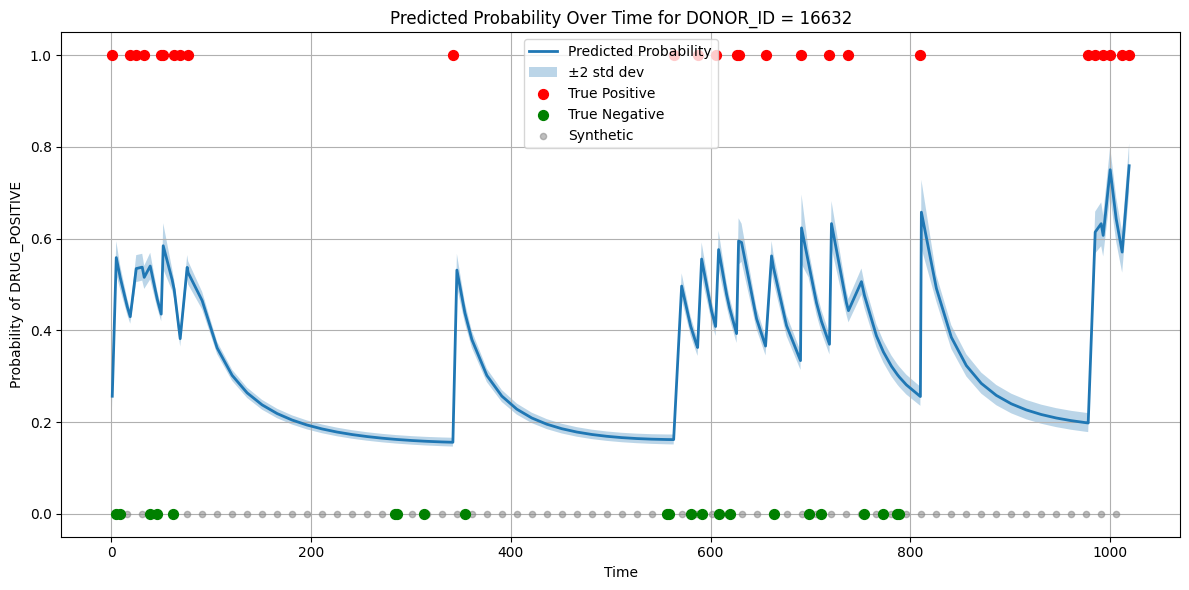

,TIME,Predicted Probability,Lower,Upper,True Target,Original
0,1,0.256407,0.231742,0.282732,1.0,True
1,5,0.558724,0.522300,0.594526,0.0,True
2,9,0.515006,0.489237,0.540696,0.0,True
3,16,0.451778,0.434405,0.469269,0.0,False
4,19,0.429872,0.414627,0.445251,1.0,True
...,...,...,...,...,...,...
107,993,0.607122,0.561296,0.651136,1.0,True
108,1000,0.750389,0.693486,0.799779,1.0,True
109,1006,0.643351,0.593456,0.690318,0.0,False
110,1012,0.570733,0.525943,0.614394,1.0,True


In [43]:
plot_predicted_probability_timeline(
    gp_model,
    donor_df,
    donor_id=16632,
    original_sample_col="ORIGINAL_SAMPLE"
)

### Evaluation of GP Classifier

In [9]:
metrics = gp_model.score(X_test)

Accuracy: 0.7325
ROC AUC : 0.7338


In [14]:
from recurrent_health_events_prediction.training.utils_survival import plot_calibration_curve


pred_proba = gp_model.predict_proba(X_test)
plot_calibration_curve(
    labels=X_test[gp_model.target_col].values,
    pred_prob=pred_proba,
    n_bins=10,
    title="Calibration Curve for GP Classifier",
)

### Save Results

In [ ]:
import json

# Define the target column and features
target_col = config['target_col']
features_used = features

# Compute statistics for X_train
train_stats = {
    "Dataset": "X_train",
    "Number of DONOR_IDs": X_train['DONOR_ID'].nunique(),
    "Number of Samples": len(X_train),
    f"Distribution of {target_col}": X_train[target_col].value_counts(normalize=True).to_dict(),
    "Features Used": features_used,
    "Features Lengthscales": features_lengthscales_dict
}

# Compute statistics for X_test
test_stats = {
    "Dataset": "X_test",
    "Number of DONOR_IDs": X_test['DONOR_ID'].nunique(),
    "Number of Samples": len(X_test),
    f"Distribution of {target_col}": X_test[target_col].value_counts(normalize=True).to_dict(),
    "Features Used": features_used,
    "metrics": metrics,
}

# Combine statistics
stats = {"X_train": train_stats, "X_test": test_stats}

# Save statistics to a JSON file
stats_path = model_path + "/dataset_statistics.json"
with open(stats_path, "w") as f:
    json.dump(stats, f, indent=4)

print(f"Statistics saved to: {stats_path}")